In [ ]:
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d

In [1]:
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Merge,Flatten,Dropout
from keras.layers import Conv1D,Reshape
import keras

# For the plots 
import matplotlib.pyplot as plt

# For controlling the training parameters in the midst of training itself
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# For creating directory to save the models
import os

Using TensorFlow backend.


In [113]:
# Load the data
X = np.load("X_d2v200.npy")
Y = np.load("Y_d2v200.npy")

In [159]:
# temp = []
# for i in Y:
#     t = np.zeros(200)
#     t[i]=1
#     temp.append(t)

# Y = np.asarray(temp)

In [114]:
# Split the test train and pass it into validation
from sklearn.utils import class_weight

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
# weights = np.array(class_weight)

In [115]:
# Reshape the stuff according to the the shape Keras expects it to be !
data_lstm = X_train[:,:200].reshape((X_train[:,:200].shape[0], 200, 1))
target = Y_train.reshape((Y_train.shape[0], 1))
# target = Y_train

val_data_lstm = X_test[:,:200].reshape(X_test[:,:200].shape[0],200,1)
val_target = Y_test.reshape(Y_test.shape[0],1)
# val_target = Y_test

In [116]:
data_mw = X_train[:,-1].reshape((X_train[:,-1].shape[0],1))
val_data_mw = X_test[:,-1].reshape((X_test[:,-1].shape[0],1))

In [117]:
val_data_mw.shape

(651, 1)

In [118]:
val_target.shape

(651, 1)

In [81]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [133]:
branch1 = Sequential()

branch1.add(Conv1D(2,3,activation='relu',input_shape=(200, 1)))
branch1.add(Conv1D(4,3,activation='relu'))
branch1.add(Conv1D(6,3,activation='relu'))
# branch1.add(Dropout(0.4))
branch1.add(Conv1D(8,3,activation='relu'))
branch1.add(Conv1D(10,3,activation='relu'))
branch1.add(Flatten())
branch1.add(Dense(10))




branch2 = Sequential()
branch2.add(Dense(10,input_dim=1))
branch2.add(Dropout(0.4))
branch2.add(Dense(10,activation='relu'))
            
            
model =Sequential()
model.add(Merge([branch1, branch2], mode = 'concat'))
model.add(Dense(1,activation='relu'))
model.add(Dense(1,activation='relu'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [84]:
# Define the output for the saving the checkpoint (best models)

outputFolder = './output-cnn'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/Weights-{epoch:02d}-{val_acc:.2f}.hdf5"

In [120]:
# The callback function for model checkpoint saving
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True,\
                             save_weights_only=True,mode='auto')

# The callback function for earlystopping

earlystop = EarlyStopping(monitor='val_loss',patience=10, \
                          verbose=1, mode='auto')

# The callback function for reducing learning rate on plateus

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

In [86]:
# Put all those calback in a list
# callbacks = [earlystop, checkpoint, reduce_lr]
callbacks = [checkpoint, reduce_lr]

In [134]:
# I have decided to use mean_absolute_error , beacuse for some reason mean squared e
#weighted_categorical_crossentropy(weights)
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['accuracy'])
model_info = model.fit([data_lstm,data_mw], target, epochs=1000, batch_size=100, verbose=2,validation_data=([val_data_lstm,val_data_mw],val_target))                   #,callbacks=callbacks, class_weight=class_weight)

Train on 2600 samples, validate on 651 samples
Epoch 1/1000
1s - loss: 70.0801 - acc: 0.1900 - val_loss: 116.7520 - val_acc: 0.0292
Epoch 2/1000
0s - loss: 68.9531 - acc: 0.0212 - val_loss: 116.1779 - val_acc: 0.0246
Epoch 3/1000
0s - loss: 68.5774 - acc: 0.0154 - val_loss: 115.6724 - val_acc: 0.0184
Epoch 4/1000
0s - loss: 68.1128 - acc: 0.0158 - val_loss: 115.4182 - val_acc: 0.0307
Epoch 5/1000
0s - loss: 67.5140 - acc: 0.0181 - val_loss: 114.3994 - val_acc: 0.0461
Epoch 6/1000
0s - loss: 66.6924 - acc: 0.0400 - val_loss: 112.9192 - val_acc: 0.0323
Epoch 7/1000
0s - loss: 65.5592 - acc: 0.0977 - val_loss: 111.5058 - val_acc: 0.1935
Epoch 8/1000
0s - loss: 64.4096 - acc: 0.1973 - val_loss: 109.9099 - val_acc: 0.2611
Epoch 9/1000
0s - loss: 63.2212 - acc: 0.2858 - val_loss: 108.7868 - val_acc: 0.4777
Epoch 10/1000
1s - loss: 61.9014 - acc: 0.3900 - val_loss: 107.4589 - val_acc: 0.5392
Epoch 11/1000
0s - loss: 60.9369 - acc: 0.4535 - val_loss: 107.0729 - val_acc: 0.6298
Epoch 12/1000
0s

0s - loss: 28.3374 - acc: 0.0388 - val_loss: 133.0677 - val_acc: 0.0292
Epoch 97/1000
0s - loss: 28.2340 - acc: 0.0358 - val_loss: 125.3102 - val_acc: 0.0292
Epoch 98/1000
0s - loss: 29.2191 - acc: 0.0377 - val_loss: 123.8843 - val_acc: 0.0307
Epoch 99/1000
0s - loss: 27.6624 - acc: 0.0365 - val_loss: 127.9686 - val_acc: 0.0292
Epoch 100/1000
0s - loss: 28.6948 - acc: 0.0373 - val_loss: 127.6521 - val_acc: 0.0292
Epoch 101/1000
0s - loss: 28.1182 - acc: 0.0388 - val_loss: 121.4532 - val_acc: 0.0323
Epoch 102/1000
0s - loss: 28.7323 - acc: 0.0388 - val_loss: 144.1611 - val_acc: 0.0292
Epoch 103/1000
0s - loss: 28.0577 - acc: 0.0385 - val_loss: 122.7686 - val_acc: 0.0307
Epoch 104/1000
0s - loss: 28.3664 - acc: 0.0358 - val_loss: 128.9605 - val_acc: 0.0292
Epoch 105/1000
0s - loss: 27.4181 - acc: 0.0377 - val_loss: 121.3290 - val_acc: 0.0307
Epoch 106/1000
0s - loss: 27.6082 - acc: 0.0373 - val_loss: 123.4624 - val_acc: 0.0307
Epoch 107/1000
0s - loss: 27.7272 - acc: 0.0362 - val_loss: 1

0s - loss: 26.9255 - acc: 0.0388 - val_loss: 125.4644 - val_acc: 0.0292
Epoch 192/1000
0s - loss: 24.6317 - acc: 0.0412 - val_loss: 120.4870 - val_acc: 0.0307
Epoch 193/1000
0s - loss: 26.0860 - acc: 0.0412 - val_loss: 124.8544 - val_acc: 0.0292
Epoch 194/1000
0s - loss: 26.1079 - acc: 0.0404 - val_loss: 128.0607 - val_acc: 0.0292
Epoch 195/1000
0s - loss: 24.8224 - acc: 0.0415 - val_loss: 127.0345 - val_acc: 0.0292
Epoch 196/1000
0s - loss: 26.2835 - acc: 0.0392 - val_loss: 116.6200 - val_acc: 0.0307
Epoch 197/1000
0s - loss: 25.6437 - acc: 0.0388 - val_loss: 126.8908 - val_acc: 0.0292
Epoch 198/1000
0s - loss: 26.2414 - acc: 0.0396 - val_loss: 127.2199 - val_acc: 0.0292
Epoch 199/1000
0s - loss: 25.2291 - acc: 0.0396 - val_loss: 131.9605 - val_acc: 0.0292
Epoch 200/1000
0s - loss: 25.7252 - acc: 0.0377 - val_loss: 122.9344 - val_acc: 0.0292
Epoch 201/1000
0s - loss: 25.6003 - acc: 0.0404 - val_loss: 124.0329 - val_acc: 0.0292
Epoch 202/1000
0s - loss: 25.4467 - acc: 0.0396 - val_loss

0s - loss: 24.3655 - acc: 0.0412 - val_loss: 121.1893 - val_acc: 0.0292
Epoch 287/1000
0s - loss: 25.1868 - acc: 0.0396 - val_loss: 126.7238 - val_acc: 0.0292
Epoch 288/1000
0s - loss: 24.5705 - acc: 0.0400 - val_loss: 128.4850 - val_acc: 0.0292
Epoch 289/1000
0s - loss: 25.5238 - acc: 0.0419 - val_loss: 122.8631 - val_acc: 0.0292
Epoch 290/1000
0s - loss: 25.1175 - acc: 0.0412 - val_loss: 123.7688 - val_acc: 0.0292
Epoch 291/1000
0s - loss: 24.8299 - acc: 0.0419 - val_loss: 122.9725 - val_acc: 0.0307
Epoch 292/1000
0s - loss: 24.4514 - acc: 0.0408 - val_loss: 126.1360 - val_acc: 0.0292
Epoch 293/1000
0s - loss: 25.0137 - acc: 0.0408 - val_loss: 120.4960 - val_acc: 0.0292
Epoch 294/1000
0s - loss: 24.8595 - acc: 0.0408 - val_loss: 127.2837 - val_acc: 0.0292
Epoch 295/1000
1s - loss: 25.0415 - acc: 0.0396 - val_loss: 124.4512 - val_acc: 0.0307
Epoch 296/1000
1s - loss: 24.5622 - acc: 0.0423 - val_loss: 147.1062 - val_acc: 0.0307
Epoch 297/1000
1s - loss: 25.3038 - acc: 0.0392 - val_loss

0s - loss: 24.5673 - acc: 0.0415 - val_loss: 120.6127 - val_acc: 0.0307
Epoch 382/1000
0s - loss: 25.0520 - acc: 0.0392 - val_loss: 120.1294 - val_acc: 0.0292
Epoch 383/1000
0s - loss: 24.1788 - acc: 0.0419 - val_loss: 125.8862 - val_acc: 0.0292
Epoch 384/1000
0s - loss: 24.7734 - acc: 0.0392 - val_loss: 119.2664 - val_acc: 0.0292
Epoch 385/1000
0s - loss: 24.7252 - acc: 0.0400 - val_loss: 123.7954 - val_acc: 0.0292
Epoch 386/1000
1s - loss: 24.5335 - acc: 0.0404 - val_loss: 122.7383 - val_acc: 0.0292
Epoch 387/1000
0s - loss: 24.8473 - acc: 0.0412 - val_loss: 121.7337 - val_acc: 0.0292
Epoch 388/1000
0s - loss: 24.3326 - acc: 0.0408 - val_loss: 126.4354 - val_acc: 0.0292
Epoch 389/1000
0s - loss: 24.5453 - acc: 0.0377 - val_loss: 126.1650 - val_acc: 0.0292
Epoch 390/1000
0s - loss: 24.5510 - acc: 0.0412 - val_loss: 119.9655 - val_acc: 0.0292
Epoch 391/1000
0s - loss: 24.3649 - acc: 0.0408 - val_loss: 133.9725 - val_acc: 0.0292
Epoch 392/1000
0s - loss: 25.2248 - acc: 0.0412 - val_loss

0s - loss: 24.1628 - acc: 0.0408 - val_loss: 128.2235 - val_acc: 0.0292
Epoch 477/1000
0s - loss: 24.9547 - acc: 0.0415 - val_loss: 129.1935 - val_acc: 0.0292
Epoch 478/1000
0s - loss: 24.4170 - acc: 0.0415 - val_loss: 124.4554 - val_acc: 0.0307
Epoch 479/1000
0s - loss: 24.5010 - acc: 0.0427 - val_loss: 124.9165 - val_acc: 0.0307
Epoch 480/1000
0s - loss: 24.4510 - acc: 0.0412 - val_loss: 122.5231 - val_acc: 0.0323
Epoch 481/1000
0s - loss: 24.2596 - acc: 0.0404 - val_loss: 120.4769 - val_acc: 0.0292
Epoch 482/1000
0s - loss: 24.8960 - acc: 0.0419 - val_loss: 122.7723 - val_acc: 0.0292
Epoch 483/1000
0s - loss: 24.4574 - acc: 0.0454 - val_loss: 126.1129 - val_acc: 0.0307
Epoch 484/1000
0s - loss: 24.3003 - acc: 0.0400 - val_loss: 126.7488 - val_acc: 0.0307
Epoch 485/1000
0s - loss: 24.7423 - acc: 0.0419 - val_loss: 123.8608 - val_acc: 0.0292
Epoch 486/1000
0s - loss: 24.0636 - acc: 0.0412 - val_loss: 122.2488 - val_acc: 0.0292
Epoch 487/1000
0s - loss: 24.7215 - acc: 0.0400 - val_loss

0s - loss: 24.4436 - acc: 0.0400 - val_loss: 128.5853 - val_acc: 0.0292
Epoch 572/1000
0s - loss: 24.3480 - acc: 0.0423 - val_loss: 124.4249 - val_acc: 0.0307
Epoch 573/1000
0s - loss: 24.0714 - acc: 0.0442 - val_loss: 124.9186 - val_acc: 0.0307
Epoch 574/1000
0s - loss: 24.7057 - acc: 0.0400 - val_loss: 129.8592 - val_acc: 0.0292
Epoch 575/1000
0s - loss: 24.6801 - acc: 0.0415 - val_loss: 122.9638 - val_acc: 0.0292
Epoch 576/1000
0s - loss: 24.3147 - acc: 0.0450 - val_loss: 125.6349 - val_acc: 0.0292
Epoch 577/1000
0s - loss: 24.2898 - acc: 0.0400 - val_loss: 122.7231 - val_acc: 0.0307
Epoch 578/1000
0s - loss: 24.3223 - acc: 0.0412 - val_loss: 124.8643 - val_acc: 0.0292
Epoch 579/1000
0s - loss: 24.6656 - acc: 0.0385 - val_loss: 126.8086 - val_acc: 0.0292
Epoch 580/1000
0s - loss: 24.5580 - acc: 0.0435 - val_loss: 123.1529 - val_acc: 0.0307
Epoch 581/1000
1s - loss: 24.3622 - acc: 0.0446 - val_loss: 128.4408 - val_acc: 0.0292
Epoch 582/1000
1s - loss: 24.3144 - acc: 0.0404 - val_loss

0s - loss: 24.4298 - acc: 0.0438 - val_loss: 132.2514 - val_acc: 0.0292
Epoch 667/1000
0s - loss: 24.0865 - acc: 0.0465 - val_loss: 123.2193 - val_acc: 0.0292
Epoch 668/1000
0s - loss: 24.1525 - acc: 0.0408 - val_loss: 121.5775 - val_acc: 0.0307
Epoch 669/1000
0s - loss: 24.3135 - acc: 0.0419 - val_loss: 119.9518 - val_acc: 0.0292
Epoch 670/1000
0s - loss: 24.3414 - acc: 0.0412 - val_loss: 122.6289 - val_acc: 0.0323
Epoch 671/1000
0s - loss: 24.2361 - acc: 0.0438 - val_loss: 122.1415 - val_acc: 0.0323
Epoch 672/1000
0s - loss: 24.3291 - acc: 0.0408 - val_loss: 123.5896 - val_acc: 0.0307
Epoch 673/1000
0s - loss: 24.2527 - acc: 0.0450 - val_loss: 125.1639 - val_acc: 0.0292
Epoch 674/1000
0s - loss: 24.6886 - acc: 0.0412 - val_loss: 122.8116 - val_acc: 0.0292
Epoch 675/1000
0s - loss: 23.8326 - acc: 0.0438 - val_loss: 126.8535 - val_acc: 0.0292
Epoch 676/1000
0s - loss: 24.2498 - acc: 0.0423 - val_loss: 129.2934 - val_acc: 0.0292
Epoch 677/1000
0s - loss: 24.0890 - acc: 0.0446 - val_loss

0s - loss: 24.3473 - acc: 0.0465 - val_loss: 123.0401 - val_acc: 0.0292
Epoch 762/1000
0s - loss: 24.2103 - acc: 0.0427 - val_loss: 131.0617 - val_acc: 0.0292
Epoch 763/1000
0s - loss: 24.2356 - acc: 0.0419 - val_loss: 122.2505 - val_acc: 0.0292
Epoch 764/1000
0s - loss: 24.0873 - acc: 0.0462 - val_loss: 124.0287 - val_acc: 0.0292
Epoch 765/1000
0s - loss: 24.2539 - acc: 0.0446 - val_loss: 124.6793 - val_acc: 0.0307
Epoch 766/1000
0s - loss: 24.4058 - acc: 0.0396 - val_loss: 122.8789 - val_acc: 0.0307
Epoch 767/1000
0s - loss: 24.1586 - acc: 0.0404 - val_loss: 122.5469 - val_acc: 0.0292
Epoch 768/1000
1s - loss: 24.1169 - acc: 0.0419 - val_loss: 123.6224 - val_acc: 0.0292
Epoch 769/1000
0s - loss: 24.2695 - acc: 0.0419 - val_loss: 117.8467 - val_acc: 0.0307
Epoch 770/1000
1s - loss: 24.4557 - acc: 0.0435 - val_loss: 122.8725 - val_acc: 0.0292
Epoch 771/1000
1s - loss: 24.4717 - acc: 0.0435 - val_loss: 124.9412 - val_acc: 0.0292
Epoch 772/1000
0s - loss: 24.0724 - acc: 0.0400 - val_loss

0s - loss: 24.0508 - acc: 0.0412 - val_loss: 121.9694 - val_acc: 0.0292
Epoch 857/1000
1s - loss: 24.3248 - acc: 0.0404 - val_loss: 124.5697 - val_acc: 0.0292
Epoch 858/1000
1s - loss: 24.2141 - acc: 0.0427 - val_loss: 120.3980 - val_acc: 0.0307
Epoch 859/1000
1s - loss: 24.0199 - acc: 0.0446 - val_loss: 136.0486 - val_acc: 0.0292
Epoch 860/1000
1s - loss: 24.3417 - acc: 0.0473 - val_loss: 123.6815 - val_acc: 0.0292
Epoch 861/1000
1s - loss: 24.0737 - acc: 0.0438 - val_loss: 122.2708 - val_acc: 0.0307
Epoch 862/1000
1s - loss: 24.2806 - acc: 0.0431 - val_loss: 125.6651 - val_acc: 0.0292
Epoch 863/1000
1s - loss: 24.2014 - acc: 0.0419 - val_loss: 122.9201 - val_acc: 0.0292
Epoch 864/1000
1s - loss: 24.2729 - acc: 0.0408 - val_loss: 123.0636 - val_acc: 0.0292
Epoch 865/1000
1s - loss: 24.1212 - acc: 0.0419 - val_loss: 119.5389 - val_acc: 0.0292
Epoch 866/1000
1s - loss: 23.9923 - acc: 0.0427 - val_loss: 125.6856 - val_acc: 0.0307
Epoch 867/1000
1s - loss: 24.5697 - acc: 0.0415 - val_loss

0s - loss: 24.1791 - acc: 0.0419 - val_loss: 122.0043 - val_acc: 0.0292
Epoch 952/1000
0s - loss: 24.2024 - acc: 0.0419 - val_loss: 123.6715 - val_acc: 0.0307
Epoch 953/1000
0s - loss: 24.2264 - acc: 0.0408 - val_loss: 122.6334 - val_acc: 0.0292
Epoch 954/1000
0s - loss: 24.5075 - acc: 0.0412 - val_loss: 123.1989 - val_acc: 0.0292
Epoch 955/1000
0s - loss: 24.0425 - acc: 0.0415 - val_loss: 121.5981 - val_acc: 0.0292
Epoch 956/1000
0s - loss: 24.3505 - acc: 0.0415 - val_loss: 124.8123 - val_acc: 0.0307
Epoch 957/1000
0s - loss: 24.0871 - acc: 0.0423 - val_loss: 120.4615 - val_acc: 0.0292
Epoch 958/1000
0s - loss: 24.1087 - acc: 0.0431 - val_loss: 121.9718 - val_acc: 0.0292
Epoch 959/1000
0s - loss: 24.0333 - acc: 0.0442 - val_loss: 119.2215 - val_acc: 0.0307
Epoch 960/1000
0s - loss: 24.2285 - acc: 0.0415 - val_loss: 122.9894 - val_acc: 0.0292
Epoch 961/1000
0s - loss: 24.1162 - acc: 0.0419 - val_loss: 122.5781 - val_acc: 0.0292
Epoch 962/1000
0s - loss: 23.9503 - acc: 0.0435 - val_loss

In [203]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


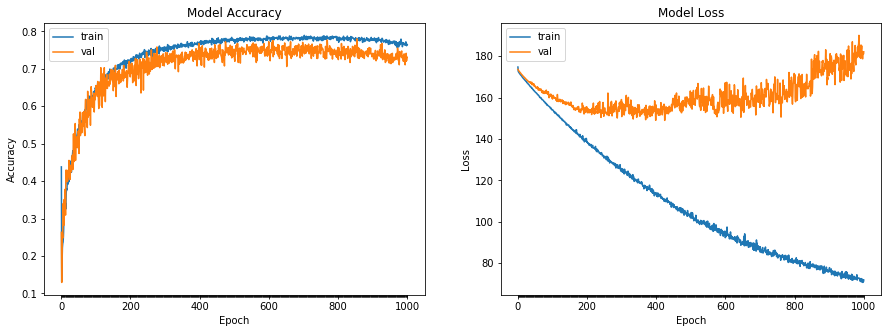

In [204]:
plot_model_history(model_info)

In [135]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(val_target, np.round(model.predict([val_data_lstm,val_data_mw])))

In [136]:
print(max(np.round(model.predict([val_data_lstm,val_data_mw]))))

[ 41.]


In [137]:
mse*19/200

11.494562211981567

In [138]:
print (max(target))

[145]


In [139]:
mean_squared_error(target,np.round(model.predict([data_lstm,data_mw])))*19/200

2.3004249999999997

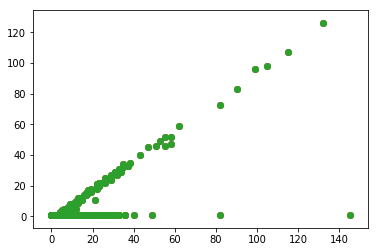

In [142]:
plt.scatter(target,np.round(model.predict([data_lstm,data_mw])))
plt.show()

In [160]:
xx = np.vstack((data_lstm,val_data_lstm))
yy = np.vstack((data_mw,val_data_mw))

In [158]:
plt.scatter(np.vstack((target,val_target)),np.round(model.predict(xx,yy)))
plt.show()

ValueError: The model expects 2  arrays, but only received one array. Found: array with shape (3251, 200, 1)

In [151]:
np.vstack((target,val_target))

array([[0],
       [0],
       [4],
       ..., 
       [0],
       [0],
       [0]])

In [249]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(val_target, np.round(model.predict([val_data_lstm,val_data_mw]))
                                               ,average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.75870801662106013, 0.6415384615384615, 0.69065262571289443, None)